In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
import copy
import json

In [2]:

from chessboard_utils import *




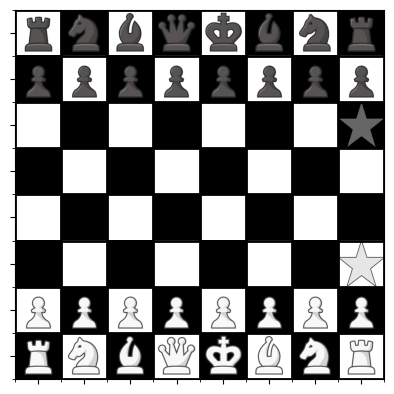

In [3]:
game_state = np.array([
    [-2, -3, -4, -6, -5, -4, -3, -2],
    [-1, -1, -1, -1, -1, -1, -1, -1],
    [ 0,  0,  0,  0,  0,  0,  0,  -7],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  7],
    [ 1,  1,  1,  1,  1,  1,  1,  1],
    [ 2,  3,  4,  6,  5,  4,  3,  2],
])

    
draw_chessboard(game_state, show=True)


In [4]:
from movement_analysis import *

from actualize_game_state import *


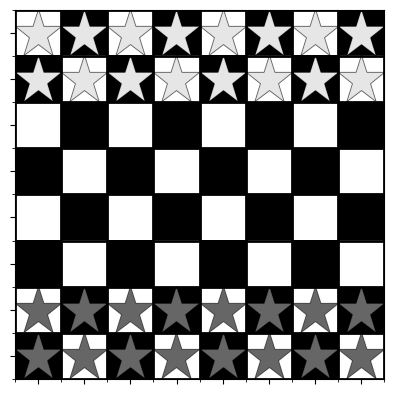


##############################################

Game state 0 (Frame: warped_frame_000100.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 1 (Frame: warped_frame_000150.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 2 (Frame: warped_frame_000200.png):
Change positions [(0, 6)]
Invalid move: No changes detected

##############################################

Game state 3 (Frame: warped_frame_000250.png):
Change positions [(1, 5), (2, 3)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 4 (Frame: warped_frame_000300.png):
Change positions [(0, 1), (0, 3), (1, 0), (1, 2), (1, 3), (1, 6), (2, 3), (2, 5), (2, 6), (2, 7), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7)]
Invalid move: Invalid number of position changes

##############################################

G

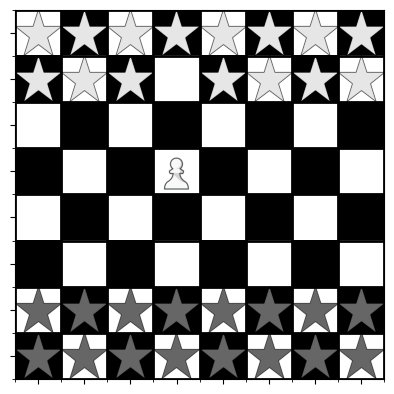


##############################################

Game state 7 (Frame: warped_frame_000450.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 8 (Frame: warped_frame_000500.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 9 (Frame: warped_frame_000550.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 10 (Frame: warped_frame_000600.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 11 (Frame: warped_frame_000650.png):
Change positions [(7, 5)]
Invalid move: No changes detected

##############################################

Game state 12 (Frame: warped_frame_000700.png):
Change positions [(5, 2), (5, 4), (7, 3), (7, 4), (7, 5)]
Invalid move: Invalid number of position changes

#####################################

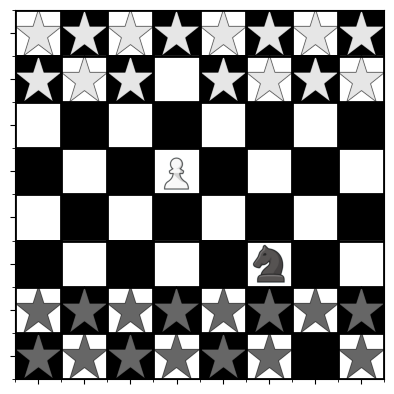


##############################################

Game state 15 (Frame: warped_frame_000850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 16 (Frame: warped_frame_000900.png):
Change positions [(0, 7), (1, 3), (1, 4), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (3, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 17 (Frame: warped_frame_000950.png):
Change positions [(0, 5), (1, 2), (1, 3), (1, 5), (2, 2), (2, 3), (2, 4), (2, 6), (2, 7), (3, 4), (3, 5)]
Invalid move: Invalid number of position changes

##############################################

Game state 18 (Frame: warped_frame_001000.png):
Change positions [(0, 7), (1, 2), (1, 7), (2, 3), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 4), (4, 5), (4, 6), (5, 6)]
Invalid move: Invalid number of position changes

##############################################

Game

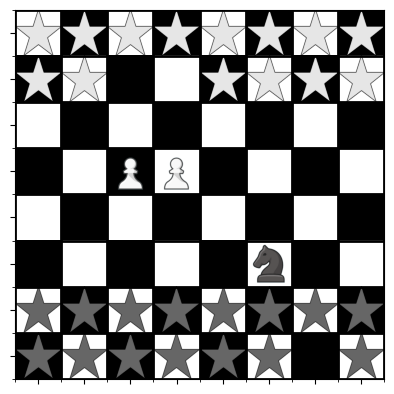


##############################################

Game state 21 (Frame: warped_frame_001150.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 22 (Frame: warped_frame_001200.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 23 (Frame: warped_frame_001250.png):
Change positions [(5, 4), (6, 5), (7, 3), (7, 5), (7, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 24 (Frame: warped_frame_001300.png):
Change positions [(5, 4), (6, 4)]
MOVEMENT ANALYSIS
valid_pieces ['black_pawn', 'black_rook', 'black_queen', 'black_king']
Move: e2 -> e3
{'black_pawn': 0.6666666666666666, 'black_rook': 0.16666666666666666, 'black_queen': 0.08333333333333333, 'black_king': 0.08333333333333333}


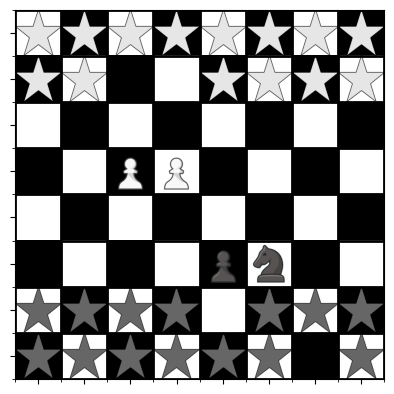


##############################################

Game state 25 (Frame: warped_frame_001350.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 26 (Frame: warped_frame_001400.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 27 (Frame: warped_frame_001450.png):
Change positions [(0, 3), (0, 6)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 28 (Frame: warped_frame_001500.png):
Change positions [(0, 1), (0, 4), (1, 2), (1, 3)]
Special case 4 positions : could be a castling
Castling positions [(0, 1), (0, 4), (1, 2), (1, 3)]
castling_movements {'valid': False, 'move_type': 'invalid', 'message': 'Rook position not found'}
Invalid move: Invalid number of position changes

##############################################

Game state 29 (Frame: warped_frame_001550.pn

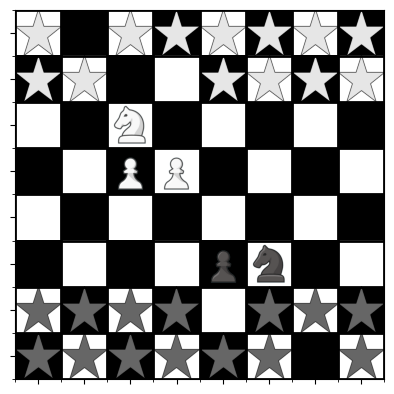


##############################################

Game state 31 (Frame: warped_frame_001650.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 32 (Frame: warped_frame_001700.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 33 (Frame: warped_frame_001750.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 34 (Frame: warped_frame_001800.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 35 (Frame: warped_frame_001850.png):
Change positions [(0, 5), (0, 7), (1, 6), (3, 2), (6, 5), (7, 5), (7, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 36 (Frame: warped_frame_001900.png):
Change positions [(0, 3), (1, 0), (1, 4), (5, 5), (6, 0), (6, 2), (6, 4), (6, 5

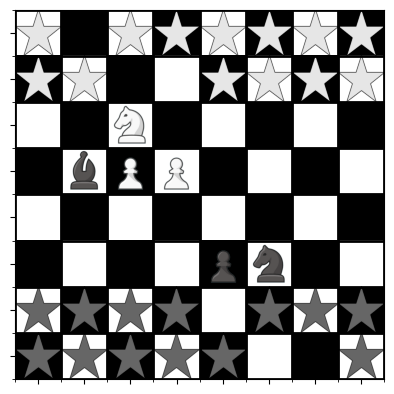


##############################################

Game state 40 (Frame: warped_frame_002100.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 41 (Frame: warped_frame_002150.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 42 (Frame: warped_frame_002200.png):
Change positions [(0, 7), (2, 5), (2, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 43 (Frame: warped_frame_002250.png):
Change positions [(1, 5), (2, 5), (2, 6), (2, 7), (3, 5), (3, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 44 (Frame: warped_frame_002300.png):
Change positions [(1, 5), (2, 5)]
MOVEMENT ANALYSIS
valid_pieces ['white_pawn', 'white_rook', 'white_queen', 'white_king']
Move: f7 -> f6
{'white_pawn': 0.6666666666666666, 'white_rook': 0.166666666666

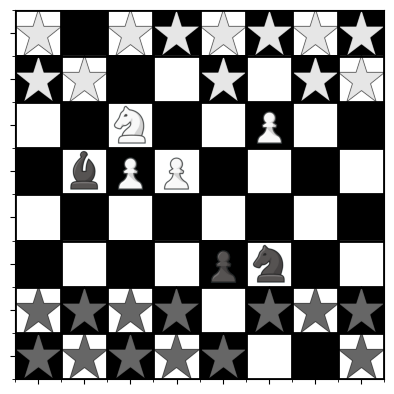


##############################################

Game state 45 (Frame: warped_frame_002350.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 46 (Frame: warped_frame_002400.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 47 (Frame: warped_frame_002450.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 48 (Frame: warped_frame_002500.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 49 (Frame: warped_frame_002550.png):
Change positions [(0, 3), (0, 5), (0, 7), (1, 0), (1, 4), (1, 6), (2, 5), (3, 2), (5, 5), (6, 3), (6, 4), (6, 5), (7, 2), (7, 3), (7, 4), (7, 5)]
Invalid move: Invalid number of position changes

##############################################

Game state 50 (Frame: warped_frame_002600.png):
Change 

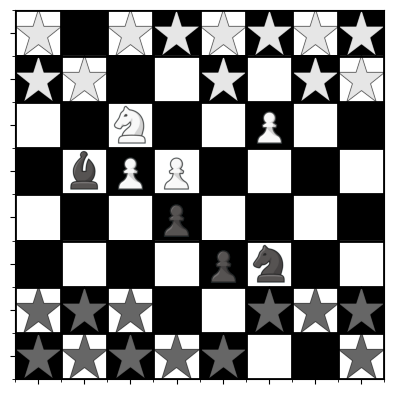


##############################################

Game state 53 (Frame: warped_frame_002750.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 54 (Frame: warped_frame_002800.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 55 (Frame: warped_frame_002850.png):
Change positions [(0, 7), (1, 5), (1, 6), (1, 7)]
Special case 4 positions : could be a castling
Castling positions [(0, 7), (1, 5), (1, 6), (1, 7)]
castling_movements {'valid': False, 'move_type': 'invalid', 'message': 'King position not found'}
Invalid move: Invalid number of position changes

##############################################

Game state 56 (Frame: warped_frame_002900.png):
Change positions [(0, 1), (0, 3), (0, 4), (0, 5), (0, 7), (1, 0), (1, 1), (1, 2), (1, 4), (1, 5), (2, 1), (2, 3)]
Invalid move: Invalid number of position changes

############################################

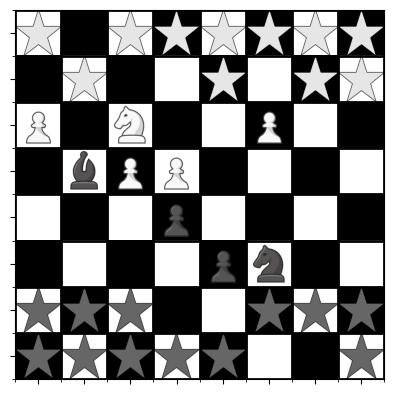


##############################################

Game state 59 (Frame: warped_frame_003050.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 60 (Frame: warped_frame_003100.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 61 (Frame: warped_frame_003150.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 62 (Frame: warped_frame_003200.png):
Change positions [(3, 0), (4, 0), (4, 1), (4, 2), (5, 1), (5, 2), (6, 2)]
Invalid move: Invalid number of position changes

##############################################

Game state 63 (Frame: warped_frame_003250.png):
Change positions [(2, 1), (2, 3), (2, 4), (3, 0), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 4), (4, 5), (4, 6), (5, 0), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 3), (6, 7), (7, 1), (7, 6)]
Inva

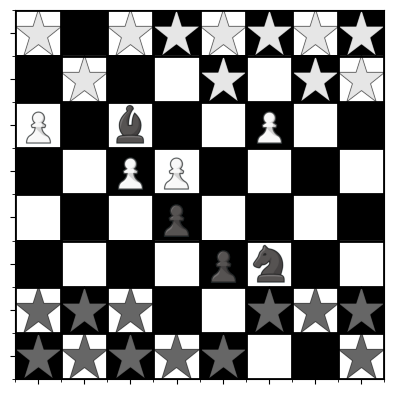


##############################################

Game state 67 (Frame: warped_frame_003450.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 68 (Frame: warped_frame_003500.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 69 (Frame: warped_frame_003550.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 70 (Frame: warped_frame_003600.png):
Change positions [(0, 4), (0, 5), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4)]
Invalid move: Invalid number of position changes

##############################################

Game state 71 (Frame: warped_frame_003650.png):
Change positions [(0, 5), (1, 1), (1, 2), (1, 3), (1, 5), (1, 7), (2, 1), (2, 3), (2, 4)]
Invalid move: Invalid number of position changes

##############################################

Game state 72 (Fra

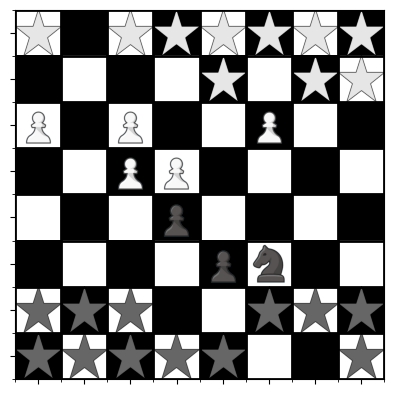


##############################################

Game state 75 (Frame: warped_frame_003850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 76 (Frame: warped_frame_003900.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 77 (Frame: warped_frame_003950.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 78 (Frame: warped_frame_004000.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 79 (Frame: warped_frame_004050.png):
Change positions [(0, 5), (0, 7), (1, 6), (2, 3), (2, 4), (3, 4), (4, 3), (4, 4), (5, 2), (5, 3), (6, 1), (6, 2), (6, 3), (7, 1), (7, 2)]
Invalid move: Invalid number of position changes

##############################################

Game state 80 (Frame: warped_frame_004100.png):
Change position

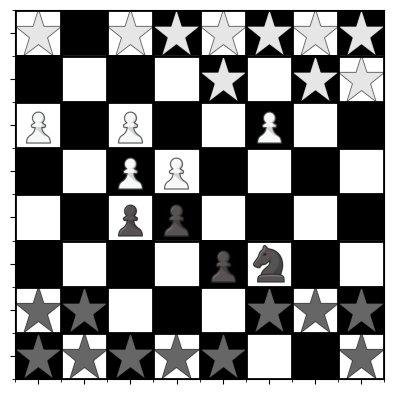


##############################################

Game state 83 (Frame: warped_frame_004250.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 84 (Frame: warped_frame_004300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 85 (Frame: warped_frame_004350.png):
Change positions [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4), (3, 2), (3, 4)]
Invalid move: Invalid number of position changes

##############################################

Game state 86 (Frame: warped_frame_004400.png):
Change positions [(0, 6), (1, 3), (1, 5), (2, 3), (2, 4), (3, 2), (3, 4)]
Invalid move: Invalid number of position changes

##############################################

Game state 87 (Frame: warped_frame_004450.png):
Change positions [(0, 6), (1, 5), (2, 4), (2, 6), (3, 2), (3, 4), (3, 5), (4, 4), (4, 5)]
Invalid move: Invalid number of position changes

#############

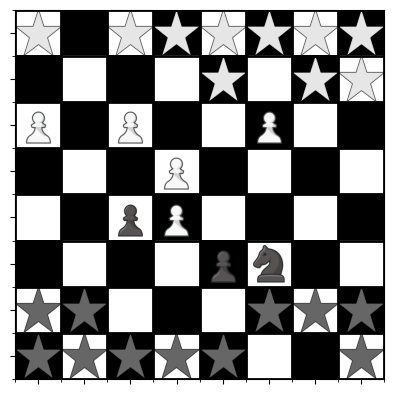


##############################################

Game state 90 (Frame: warped_frame_004600.png):
Change positions [(0, 3), (0, 5), (0, 7), (1, 4), (1, 6), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (3, 7), (4, 1), (4, 5), (4, 6), (4, 7), (5, 2), (5, 3), (5, 6), (5, 7), (6, 3), (6, 4), (7, 3), (7, 4)]
Invalid move: Invalid number of position changes

##############################################

Game state 91 (Frame: warped_frame_004650.png):
Change positions [(2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 1), (4, 2), (4, 5), (4, 6), (4, 7), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 2), (6, 3), (6, 6), (7, 1), (7, 3), (7, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 92 (Frame: warped_frame_004700.png):
Change positions [(3, 4), (3, 5), (3, 6), (3, 7), (4, 3), (4, 4), (4, 5), (4, 6), (5, 2), (5, 3), (5, 5), (5, 6), (5, 7), (6, 4), (6, 5), (7, 5)]
Invalid move: Invalid number of position chan

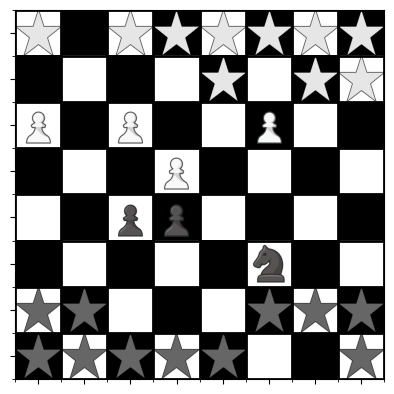


##############################################

Game state 94 (Frame: warped_frame_004800.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 95 (Frame: warped_frame_004850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 96 (Frame: warped_frame_004900.png):
Change positions [(0, 5), (1, 4), (1, 5), (2, 6)]
Special case 4 positions : could be a castling
Castling positions [(0, 5), (1, 4), (1, 5), (2, 6)]
castling_movements {'valid': False, 'move_type': 'invalid', 'message': 'King position not found'}
Invalid move: Invalid number of position changes

##############################################

Game state 97 (Frame: warped_frame_004950.png):
Change positions [(0, 7), (1, 4), (2, 4), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 98 (Frame

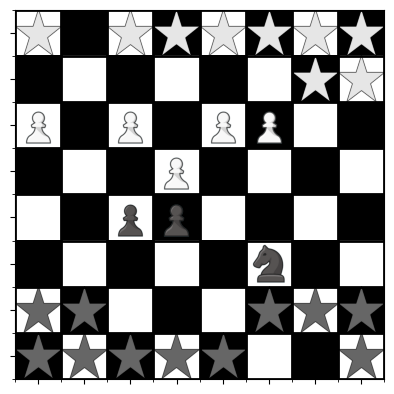


##############################################

Game state 99 (Frame: warped_frame_005050.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 100 (Frame: warped_frame_005100.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 101 (Frame: warped_frame_005150.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 102 (Frame: warped_frame_005200.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 103 (Frame: warped_frame_005250.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 104 (Frame: warped_frame_005300.png):
Change positions [(7, 2)]
Invalid move: No changes detected

##############################################

Game state 105 (Frame: warped_fram

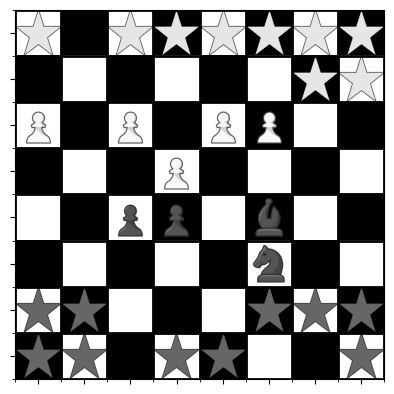


##############################################

Game state 109 (Frame: warped_frame_005550.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 110 (Frame: warped_frame_005600.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 111 (Frame: warped_frame_005650.png):
Change positions [(0, 7)]
Invalid move: No changes detected

##############################################

Game state 112 (Frame: warped_frame_005700.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 113 (Frame: warped_frame_005750.png):
Change positions [(0, 6), (1, 6), (2, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 114 (Frame: warped_frame_005800.png):
Change positions [(0, 6), (1, 4), (1, 5), (2, 6)]
Special case 4 positions : could be a castling
Ca

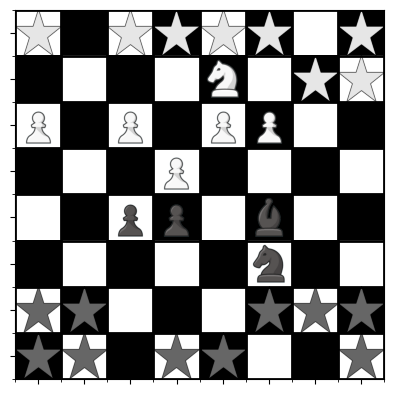


##############################################

Game state 116 (Frame: warped_frame_005900.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 117 (Frame: warped_frame_005950.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 118 (Frame: warped_frame_006000.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 119 (Frame: warped_frame_006050.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 120 (Frame: warped_frame_006100.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 121 (Frame: warped_frame_006150.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 122 (Frame: warped_frame_006

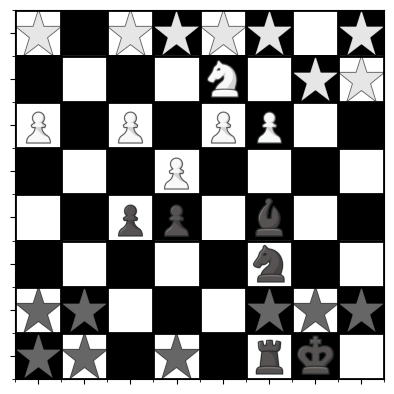


##############################################

Game state 135 (Frame: warped_frame_006850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 136 (Frame: warped_frame_006900.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 137 (Frame: warped_frame_006950.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 138 (Frame: warped_frame_007000.png):
Change positions [(2, 0)]
Invalid move: No changes detected

##############################################

Game state 139 (Frame: warped_frame_007050.png):
Change positions [(0, 7), (1, 7)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 140 (Frame: warped_frame_007100.png):
Change positions [(0, 7), (1, 6), (2, 7)]
Invalid move: Invalid number of p

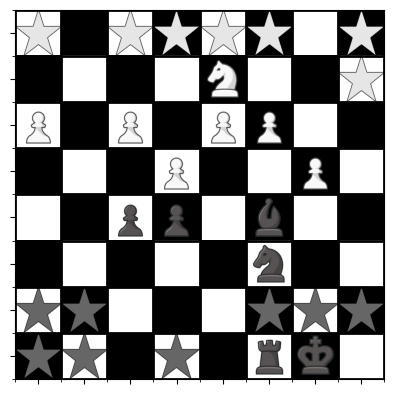


##############################################

Game state 143 (Frame: warped_frame_007250.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 144 (Frame: warped_frame_007300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 145 (Frame: warped_frame_007350.png):
Change positions [(7, 4), (7, 5), (7, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 146 (Frame: warped_frame_007400.png):
Change positions [(4, 7), (5, 6), (5, 7), (6, 6), (6, 7), (7, 2), (7, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 147 (Frame: warped_frame_007450.png):
Change positions [(4, 2), (4, 5), (4, 6), (4, 7), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 3), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 7)]
Invalid move: Invalid number of po

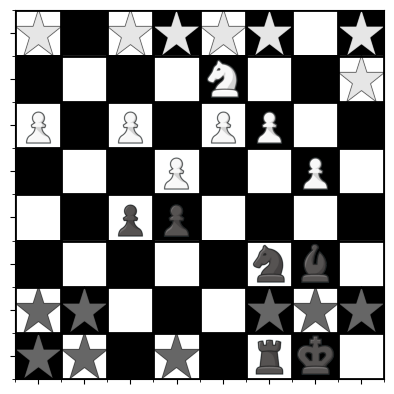


##############################################

Game state 163 (Frame: warped_frame_008250.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 164 (Frame: warped_frame_008300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 165 (Frame: warped_frame_008350.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 166 (Frame: warped_frame_008400.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 167 (Frame: warped_frame_008450.png):
Change positions [(0, 6), (1, 5), (1, 6), (2, 6), (2, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 168 (Frame: warped_frame_008500.png):
Change positions [(0, 6), (0, 7), (1, 4), (1, 5), (1, 6), (2, 5), (2, 6), (2, 7)]
Invalid

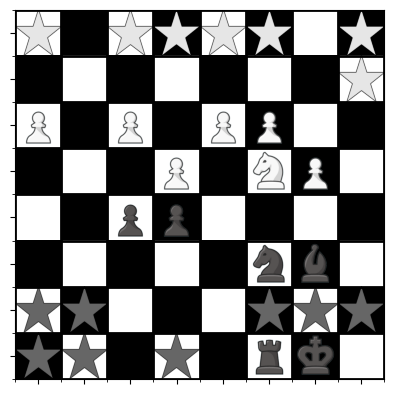


##############################################

Game state 171 (Frame: warped_frame_008650.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 172 (Frame: warped_frame_008700.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 173 (Frame: warped_frame_008750.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 174 (Frame: warped_frame_008800.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 175 (Frame: warped_frame_008850.png):
Change positions [(7, 1), (7, 2)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 176 (Frame: warped_frame_008900.png):
Change positions [(7, 1)]
Invalid move: No changes detected

####################

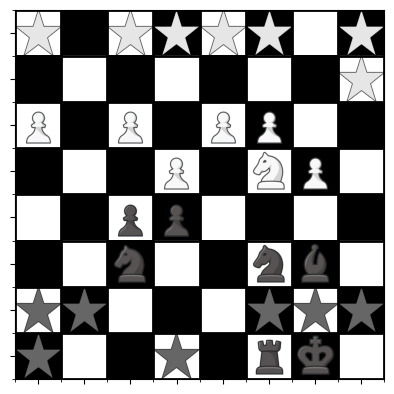


##############################################

Game state 181 (Frame: warped_frame_009150.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 182 (Frame: warped_frame_009200.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 183 (Frame: warped_frame_009250.png):
Change positions [(0, 6)]
Invalid move: No changes detected

##############################################

Game state 184 (Frame: warped_frame_009300.png):
Change positions [(0, 5), (1, 6)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 185 (Frame: warped_frame_009350.png):
Change positions [(0, 5), (1, 6)]
MOVEMENT ANALYSIS
valid_pieces ['white_bishop', 'white_queen', 'white_king']
Move: f8 -> g7
{'white_bishop': 0.5, 'white_queen': 0.25, 'white_king': 0.25}


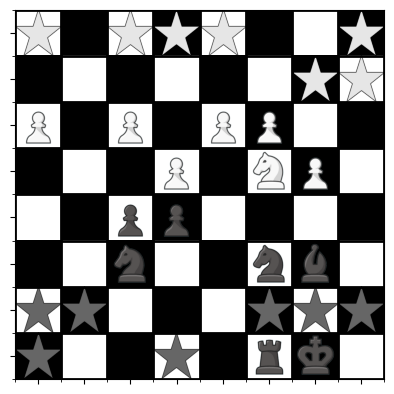


##############################################

Game state 186 (Frame: warped_frame_009400.png):
Change positions [(2, 0)]
Invalid move: No changes detected

##############################################

Game state 187 (Frame: warped_frame_009450.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 188 (Frame: warped_frame_009500.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 189 (Frame: warped_frame_009550.png):
Change positions [(7, 1), (7, 2)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 190 (Frame: warped_frame_009600.png):
Change positions [(0, 1), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (3, 3), (3, 5), (3, 6), (4, 2), (4, 3), (5, 0), (5, 1), (5, 3), (5, 4), (5, 6), (5, 7), (6, 2), (7, 0), (

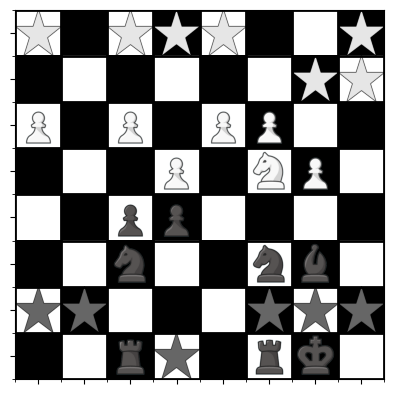


##############################################

Game state 193 (Frame: warped_frame_009750.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 194 (Frame: warped_frame_009800.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 195 (Frame: warped_frame_009850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 196 (Frame: warped_frame_009900.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 197 (Frame: warped_frame_009950.png):
Change positions [(0, 5), (0, 6), (0, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 198 (Frame: warped_frame_010000.png):
Change positions [(0, 4), (0, 5), (0, 6), (1, 4), (1, 5), (1, 6), (1, 7)]
Invalid move: Invalid number of

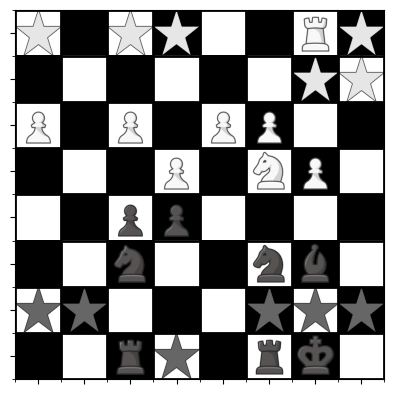


##############################################

Game state 201 (Frame: warped_frame_010150.png):
Change positions [(0, 7)]
Invalid move: No changes detected

##############################################

Game state 202 (Frame: warped_frame_010200.png):
Change positions [(0, 5), (0, 6), (0, 7), (1, 5), (1, 6), (2, 6), (2, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 203 (Frame: warped_frame_010250.png):
Change positions [(0, 5), (0, 7)]
MOVEMENT ANALYSIS
CASTLING IN TWO STEPS DETECTED !!!!!!!!!!!!!!!
{'king': {'white_king': 1.0}, 'rook': {'white_rook': 1.0}}


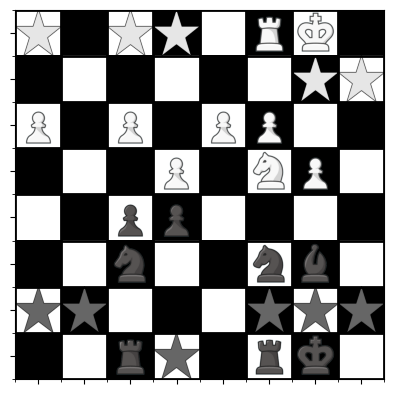


##############################################

Game state 204 (Frame: warped_frame_010300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 205 (Frame: warped_frame_010350.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 206 (Frame: warped_frame_010400.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 207 (Frame: warped_frame_010450.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 208 (Frame: warped_frame_010500.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 209 (Frame: warped_frame_010550.png):
Change positions [(4, 1), (5, 0), (5, 1), (5, 2), (6, 2), (6, 3), (7, 0), (7, 1)]
Invalid move: Invalid number of position changes

##########

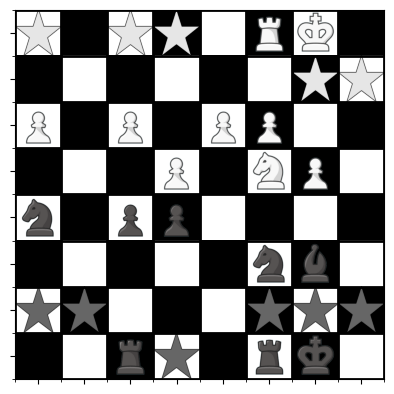


##############################################

Game state 227 (Frame: warped_frame_011450.png):
Change positions [(2, 0)]
Invalid move: No changes detected

##############################################

Game state 228 (Frame: warped_frame_011500.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 229 (Frame: warped_frame_011550.png):
Change positions [(0, 1), (0, 2)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 230 (Frame: warped_frame_011600.png):
Change positions [(0, 1), (0, 3), (1, 0), (1, 2)]
Special case 4 positions : could be a castling
Castling positions [(0, 1), (0, 3), (1, 0), (1, 2)]
castling_movements {'valid': False, 'move_type': 'invalid', 'message': 'King position not found'}
Invalid move: Invalid number of position changes

##############################################

Game state 231 (Frame: warped_fram

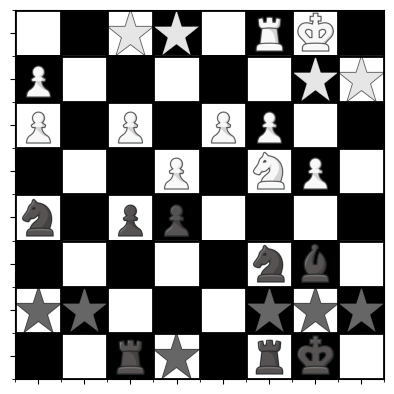


##############################################

Game state 233 (Frame: warped_frame_011750.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 234 (Frame: warped_frame_011800.png):
Change positions [(4, 6), (4, 7), (5, 7), (6, 3), (6, 4), (6, 5), (7, 2), (7, 3), (7, 5)]
Invalid move: Invalid number of position changes

##############################################

Game state 235 (Frame: warped_frame_011850.png):
Change positions [(3, 7), (4, 0), (4, 2), (4, 6), (4, 7), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 3), (6, 5), (6, 6), (7, 3), (7, 5)]
Invalid move: Invalid number of position changes

##############################################

Game state 236 (Frame: warped_frame_011900.png):
Change positions [(5, 7), (6, 7)]
MOVEMENT ANALYSIS
valid_pieces ['black_pawn', 'black_rook', 'black_queen', 'black_king']
Move: h2 -> h3
{'black_pawn': 0.6666666666666666, 'black_rook': 0.16666666666666666, 'black_queen': 0.083

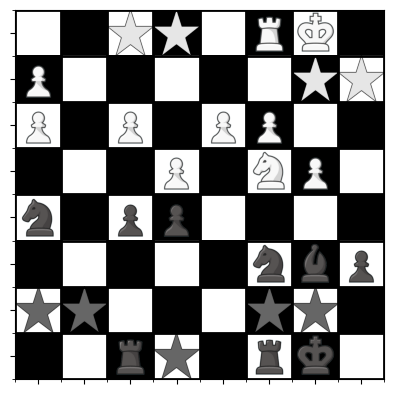


##############################################

Game state 237 (Frame: warped_frame_011950.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 238 (Frame: warped_frame_012000.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 239 (Frame: warped_frame_012050.png):
Change positions [(0, 5), (0, 7), (1, 0), (2, 6), (2, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 240 (Frame: warped_frame_012100.png):
Change positions [(0, 7), (2, 6), (3, 5), (3, 6), (4, 5)]
Invalid move: Invalid number of position changes

##############################################

Game state 241 (Frame: warped_frame_012150.png):
Change positions [(0, 7), (1, 7), (2, 7), (3, 5), (3, 7), (4, 7), (5, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 242 (

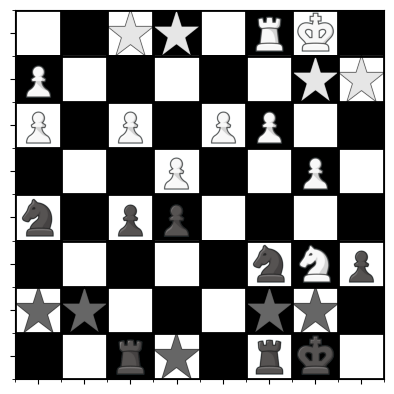


##############################################

Game state 247 (Frame: warped_frame_012450.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 248 (Frame: warped_frame_012500.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 249 (Frame: warped_frame_012550.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 250 (Frame: warped_frame_012600.png):
Change positions [(5, 4), (6, 6), (6, 7), (7, 6), (7, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 251 (Frame: warped_frame_012650.png):
Change positions [(4, 5), (5, 4), (5, 5), (5, 6), (6, 3), (6, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 252 (Frame: warped_frame_012700.png):
Change positions [(5, 4), (5

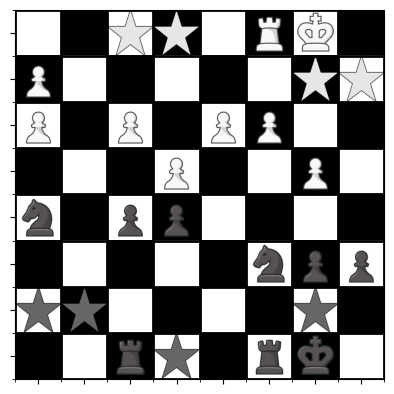


##############################################

Game state 255 (Frame: warped_frame_012850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 256 (Frame: warped_frame_012900.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 257 (Frame: warped_frame_012950.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 258 (Frame: warped_frame_013000.png):
Change positions [(0, 6), (0, 7), (1, 6), (2, 6), (2, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 259 (Frame: warped_frame_013050.png):
Change positions [(0, 4), (0, 7), (1, 4), (1, 5), (1, 7), (2, 6), (2, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 260 (Frame: warped_frame_013100.png):
Change positions [(0

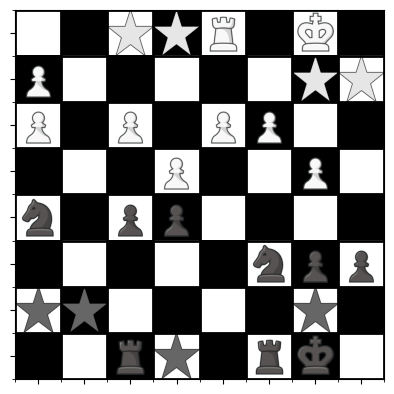


##############################################

Game state 261 (Frame: warped_frame_013150.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 262 (Frame: warped_frame_013200.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 263 (Frame: warped_frame_013250.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 264 (Frame: warped_frame_013300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 265 (Frame: warped_frame_013350.png):
Change positions [(4, 3), (5, 2), (5, 6), (6, 2), (6, 3), (6, 4), (7, 0), (7, 4), (7, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 266 (Frame: warped_frame_013400.png):
Change positions [(1, 0), (5, 2), (7, 2)]
Invalid move: I

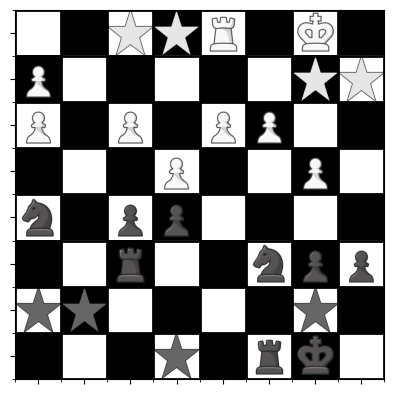


##############################################

Game state 270 (Frame: warped_frame_013600.png):
Change positions [(0, 5), (1, 4)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 271 (Frame: warped_frame_013650.png):
Change positions [(0, 1), (0, 4), (0, 5), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 6), (2, 7), (3, 2), (3, 3), (3, 4), (3, 5), (3, 7), (4, 4), (4, 5), (4, 6), (4, 7), (5, 3), (5, 4), (6, 2), (6, 3), (6, 4), (7, 1), (7, 2), (7, 4)]
Invalid move: Invalid number of position changes

##############################################

Game state 272 (Frame: warped_frame_013700.png):
Change positions [(0, 1), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 4), (2, 1), (4, 3), (5, 2), (5, 6), (6, 1), (7, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 273 (Frame: warped_fr

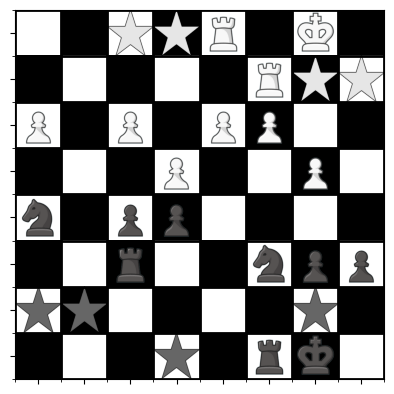


##############################################

Game state 275 (Frame: warped_frame_013850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 276 (Frame: warped_frame_013900.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 277 (Frame: warped_frame_013950.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 278 (Frame: warped_frame_014000.png):
Change positions [(2, 3), (3, 2), (3, 3), (4, 1), (4, 3), (5, 1), (5, 6), (6, 2), (7, 0), (7, 1), (7, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 279 (Frame: warped_frame_014050.png):
Change positions [(0, 3), (1, 6), (2, 2), (2, 3), (2, 5), (3, 1), (3, 3), (3, 6), (4, 1), (4, 2), (5, 0), (5, 1), (6, 1), (6, 2), (7, 0), (7, 2)]
Invalid move: Invalid number of position change

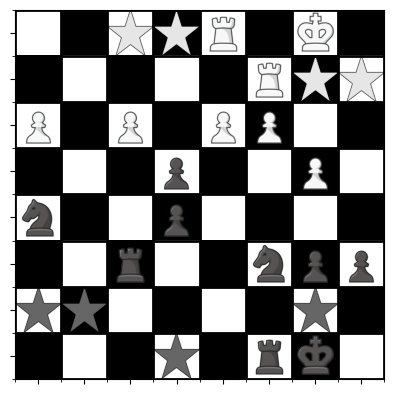


##############################################

Game state 284 (Frame: warped_frame_014300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 285 (Frame: warped_frame_014350.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 286 (Frame: warped_frame_014400.png):
Change positions [(0, 5), (0, 6), (0, 7), (1, 4), (1, 5)]
Invalid move: Invalid number of position changes

##############################################

Game state 287 (Frame: warped_frame_014450.png):
Change positions [(0, 5), (0, 7), (1, 3), (1, 4), (2, 3), (3, 2)]
Invalid move: Invalid number of position changes

##############################################

Game state 288 (Frame: warped_frame_014500.png):
Change positions [(0, 5), (0, 6), (0, 7), (1, 4), (2, 2), (2, 6), (3, 3), (3, 4), (3, 5)]
Invalid move: Invalid number of position changes

########################################

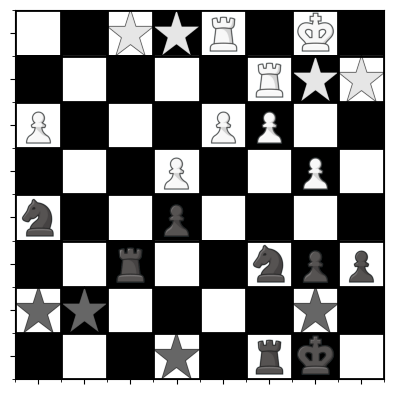


##############################################

Game state 291 (Frame: warped_frame_014650.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 292 (Frame: warped_frame_014700.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 293 (Frame: warped_frame_014750.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 294 (Frame: warped_frame_014800.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 295 (Frame: warped_frame_014850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 296 (Frame: warped_frame_014900.png):
Change positions [(7, 2)]
Invalid move: No changes detected

##############################################

Game state 297 (Frame: warped_fra

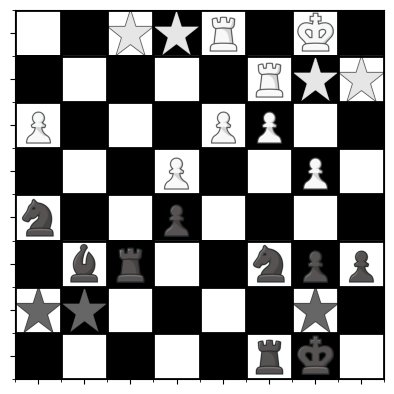


##############################################

Game state 302 (Frame: warped_frame_015200.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 303 (Frame: warped_frame_015250.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 304 (Frame: warped_frame_015300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 305 (Frame: warped_frame_015350.png):
Change positions [(0, 7), (1, 6), (2, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 306 (Frame: warped_frame_015400.png):
Change positions [(0, 7), (2, 6), (2, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 307 (Frame: warped_frame_015450.png):
Change positions [(0, 3), (0, 7), (1, 4), (1, 5), (2, 5), (2, 6), (2

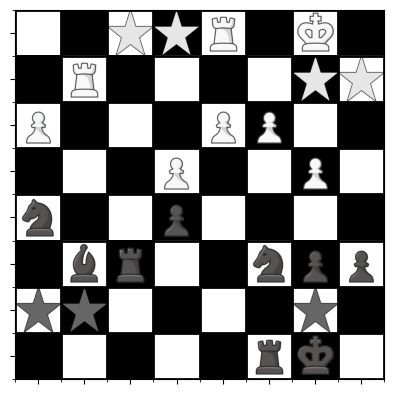


##############################################

Game state 310 (Frame: warped_frame_015600.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 311 (Frame: warped_frame_015650.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 312 (Frame: warped_frame_015700.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 313 (Frame: warped_frame_015750.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 314 (Frame: warped_frame_015800.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 315 (Frame: warped_frame_015850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 316 (Frame: warped_frame_015

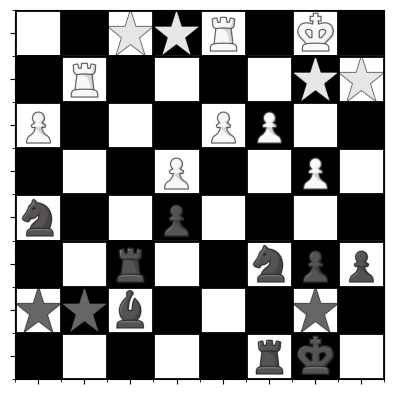


##############################################

Game state 321 (Frame: warped_frame_016150.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 322 (Frame: warped_frame_016200.png):
Change positions [(2, 0)]
Invalid move: No changes detected

##############################################

Game state 323 (Frame: warped_frame_016250.png):
Change positions [(0, 5), (0, 7), (1, 4), (1, 5), (2, 5), (3, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 324 (Frame: warped_frame_016300.png):
Change positions [(0, 5), (0, 7), (1, 5), (2, 6), (3, 4), (3, 5)]
Invalid move: Invalid number of position changes

##############################################

Game state 325 (Frame: warped_frame_016350.png):
Change positions [(0, 5), (2, 4), (3, 4)]
Invalid move: Invalid number of position changes

##############################################

Game state 326 (Frame: war

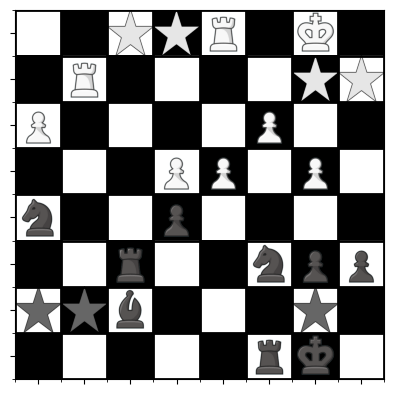


##############################################

Game state 327 (Frame: warped_frame_016450.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 328 (Frame: warped_frame_016500.png):
Change positions [(0, 0), (0, 1), (0, 4), (0, 5), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 5), (3, 7), (4, 0), (4, 1), (4, 2), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 3), (5, 4), (5, 5), (5, 7), (6, 0), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 329 (Frame: warped_frame_016550.png):
Change positions [(0, 0), (0, 1), (0, 4), (0, 5), (0, 6), (1, 2), (1, 5), (2, 0), (2, 2), (2, 3), (2, 4), (2, 6), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (4, 0), (4, 1), (4, 3), (4, 6), (5, 0), (5, 1),

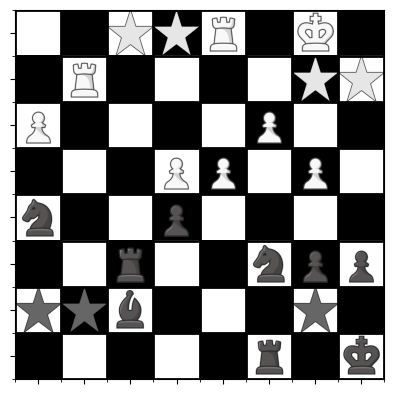


##############################################

Game state 331 (Frame: warped_frame_016650.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 332 (Frame: warped_frame_016700.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 333 (Frame: warped_frame_016750.png):
Change positions [(0, 3), (0, 7), (1, 5), (2, 4), (2, 6), (3, 4), (3, 5), (3, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 334 (Frame: warped_frame_016800.png):
Change positions [(0, 3), (0, 6), (0, 7), (1, 5), (1, 6), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 4), (4, 5), (4, 6), (4, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 335 (Frame: warped_frame_016850.png):
Change positions [(0, 5), (0, 7), (3, 4), (4, 4)]
Special case 4 positions : could b

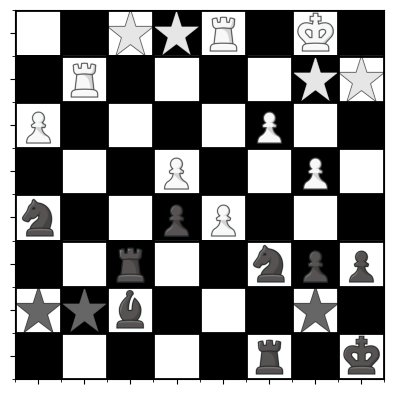


##############################################

Game state 337 (Frame: warped_frame_016950.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 338 (Frame: warped_frame_017000.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 339 (Frame: warped_frame_017050.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 340 (Frame: warped_frame_017100.png):
Change positions [(5, 4), (6, 3), (6, 4), (6, 5), (7, 4), (7, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 341 (Frame: warped_frame_017150.png):
Change positions [(5, 5), (6, 5), (7, 4), (7, 6)]
Special case 4 positions : could be a castling
Castling positions [(5, 5), (6, 5), (7, 4), (7, 6)]
castling_movements {'valid': False, 'move_type': 'invalid', 'message': 'King positio

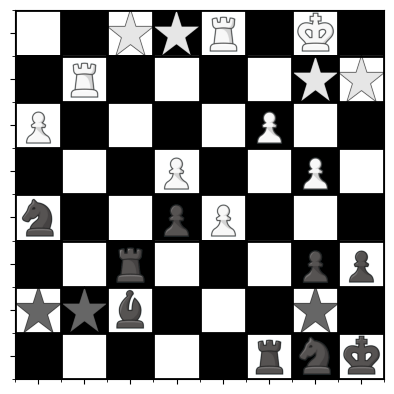


##############################################

Game state 343 (Frame: warped_frame_017250.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 344 (Frame: warped_frame_017300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 345 (Frame: warped_frame_017350.png):
Change positions [(0, 7)]
Invalid move: No changes detected

##############################################

Game state 346 (Frame: warped_frame_017400.png):
Change positions [(0, 3), (0, 7), (1, 5), (2, 5), (2, 6), (2, 7), (3, 5), (3, 6), (3, 7), (4, 6), (4, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 347 (Frame: warped_frame_017450.png):
Change positions [(0, 7), (2, 5), (2, 7), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7)]
Invalid move: Invalid number of position changes

#######################################

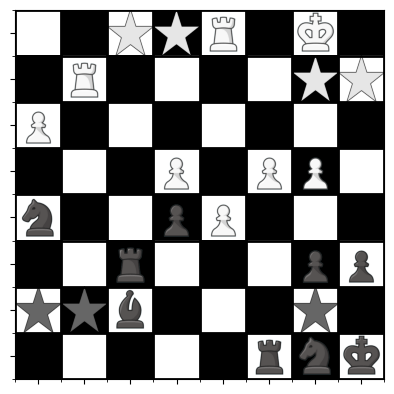


##############################################

Game state 349 (Frame: warped_frame_017550.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 350 (Frame: warped_frame_017600.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 351 (Frame: warped_frame_017650.png):
Change positions [(6, 5), (7, 4)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 352 (Frame: warped_frame_017700.png):
Change positions [(7, 4), (7, 5)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 353 (Frame: warped_frame_017750.png):
Change positions [(6, 5), (7, 3), (7, 4)]
Invalid move: Invalid number of position changes

##############################################

Game state 354 (Frame: warped_fr

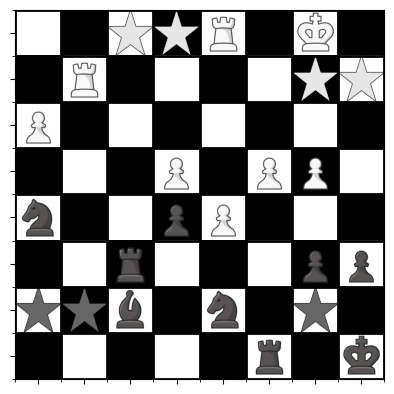


##############################################

Game state 355 (Frame: warped_frame_017850.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 356 (Frame: warped_frame_017900.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 357 (Frame: warped_frame_017950.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 358 (Frame: warped_frame_018000.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 359 (Frame: warped_frame_018050.png):
Change positions [(0, 1), (0, 3), (0, 5), (1, 2), (1, 4), (4, 3), (5, 2), (5, 6), (6, 1)]
Invalid move: Invalid number of position changes

##############################################

Game state 360 (Frame: warped_frame_018100.png):
Change positions [(0, 1), (0, 3), (0, 4), (0, 5), (1, 1),

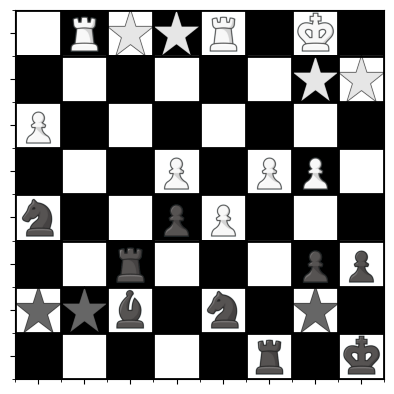


##############################################

Game state 362 (Frame: warped_frame_018200.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 363 (Frame: warped_frame_018250.png):
Change positions [(1, 6), (3, 6)]
MOVEMENT ANALYSIS
Invalid move: Final piece is not the same as the initial piece

##############################################

Game state 364 (Frame: warped_frame_018300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 365 (Frame: warped_frame_018350.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 366 (Frame: warped_frame_018400.png):
Change positions [(0, 0), (0, 1), (0, 3), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6),

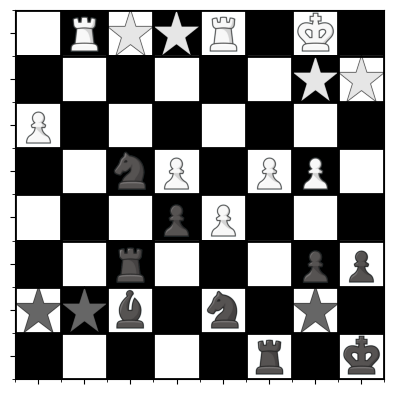


##############################################

Game state 378 (Frame: warped_frame_019000.png):
Change positions [(0, 1), (0, 4), (0, 5), (0, 7), (1, 3), (1, 4), (1, 5), (3, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 379 (Frame: warped_frame_019050.png):
Change positions [(0, 1), (0, 3), (0, 5), (0, 7), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4)]
Invalid move: Invalid number of position changes

##############################################

Game state 380 (Frame: warped_frame_019100.png):
Change positions [(0, 3), (0, 5), (1, 7), (2, 3)]
Special case 4 positions : could be a castling
Castling positions [(0, 3), (0, 5), (1, 7), (2, 3)]
castling_movements {'valid': False, 'move_type': 'invalid', 'message': 'King position not found'}
Invalid move: Invalid number of position changes

##############################################

Game state 381 (Frame: warped_frame_019150.

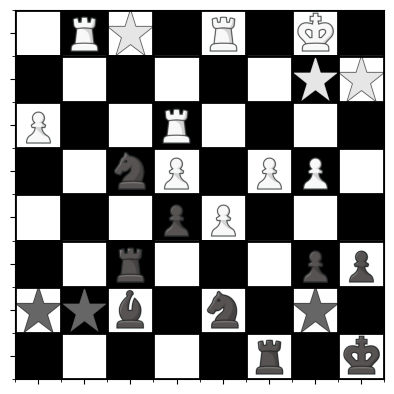


##############################################

Game state 382 (Frame: warped_frame_019200.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 383 (Frame: warped_frame_019250.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 384 (Frame: warped_frame_019300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 385 (Frame: warped_frame_019350.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 386 (Frame: warped_frame_019400.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 387 (Frame: warped_frame_019450.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 388 (Frame: warped_frame_019

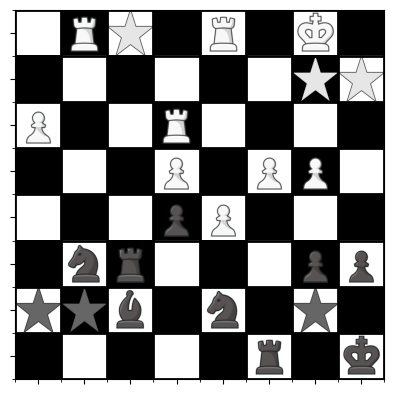


##############################################

Game state 397 (Frame: warped_frame_019950.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 398 (Frame: warped_frame_020000.png):
Change positions [(0, 1)]
Invalid move: No changes detected

##############################################

Game state 399 (Frame: warped_frame_020050.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 400 (Frame: warped_frame_020100.png):
Change positions [(0, 3), (1, 2), (1, 3)]
Invalid move: Invalid number of position changes

##############################################

Game state 401 (Frame: warped_frame_020150.png):
Change positions [(0, 3), (1, 2), (1, 3)]
Invalid move: Invalid number of position changes

##############################################

Game state 402 (Frame: warped_frame_020200.png):
Change positions [(0, 2), (0, 3), (0, 5), (1, 3), (1, 4)]
Inva

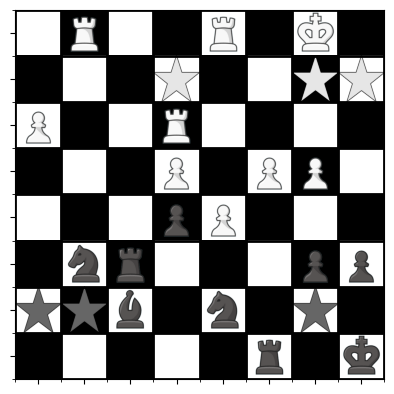


##############################################

Game state 404 (Frame: warped_frame_020300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 405 (Frame: warped_frame_020350.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 406 (Frame: warped_frame_020400.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 407 (Frame: warped_frame_020450.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 408 (Frame: warped_frame_020500.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 409 (Frame: warped_frame_020550.png):
Change positions [(0, 1), (5, 0), (5, 1), (6, 0), (6, 1), (6, 2), (6, 3), (7, 0), (7, 1), (7, 3)]
Invalid move: Invalid number of position cha

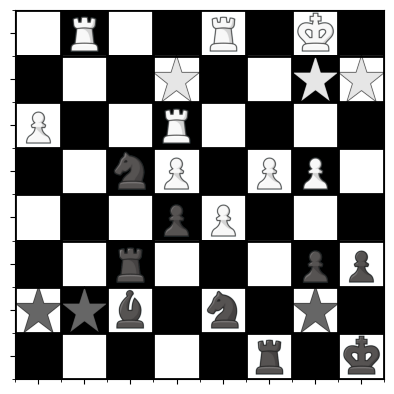


##############################################

Game state 416 (Frame: warped_frame_020900.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 417 (Frame: warped_frame_020950.png):
Change positions [(0, 1)]
Invalid move: No changes detected

##############################################

Game state 418 (Frame: warped_frame_021000.png):
Change positions [(0, 5), (0, 7), (2, 6), (2, 7)]
Special case 4 positions : could be a castling
Castling positions [(0, 5), (0, 7), (2, 6), (2, 7)]
castling_movements {'valid': False, 'move_type': 'invalid', 'message': 'King position not found'}
Invalid move: Invalid number of position changes

##############################################

Game state 419 (Frame: warped_frame_021050.png):
Change positions [(0, 3), (0, 5), (0, 7), (1, 4), (1, 5), (1, 6), (1, 7), (2, 4), (2, 5), (2, 6)]
Invalid move: Invalid number of position changes

##############################################

Ga

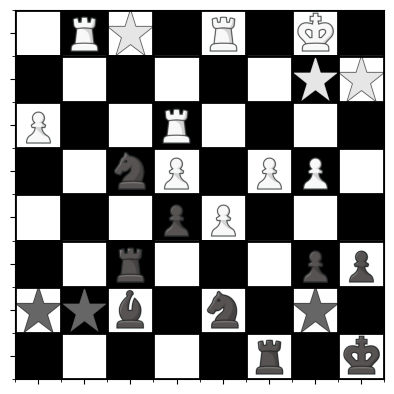


##############################################

Game state 423 (Frame: warped_frame_021250.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 424 (Frame: warped_frame_021300.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 425 (Frame: warped_frame_021350.png):
Change positions [(0, 0), (0, 2), (0, 3), (0, 5), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 4), (3, 7), (4, 0), (4, 1), (4, 2), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 5), (6, 6), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 6)]
Invalid move: Invalid number of position changes

##############################################

Game state 426 (Frame: warped_frame_021400.png):
Change positions [(3, 2),

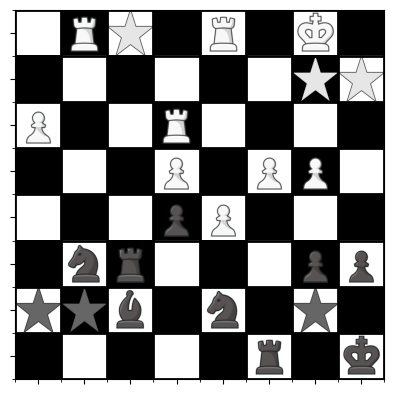


##############################################

Game state 428 (Frame: warped_frame_021500.png):
Change positions [(0, 1)]
Invalid move: No changes detected

##############################################

Game state 429 (Frame: warped_frame_021550.png):
Change positions [(0, 3), (0, 5), (1, 2), (1, 3)]
Special case 4 positions : could be a castling
Castling positions [(0, 3), (0, 5), (1, 2), (1, 3)]
castling_movements {'valid': False, 'move_type': 'invalid', 'message': 'King position not found'}
Invalid move: Invalid number of position changes

##############################################

Game state 430 (Frame: warped_frame_021600.png):
Change positions [(0, 0), (0, 3), (0, 5), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 

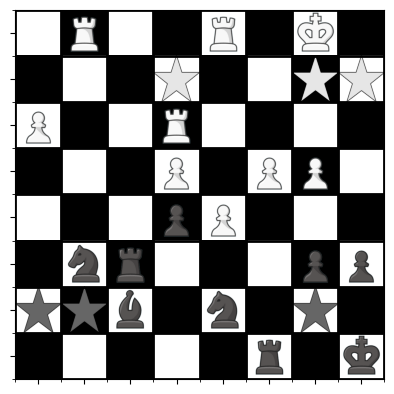


##############################################

Game state 432 (Frame: warped_frame_021700.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 433 (Frame: warped_frame_021750.png):
Change positions []
Invalid move: No changes detected

##############################################

Game state 434 (Frame: warped_frame_021800.png):
Change positions [(1, 0), (1, 1), (1, 2), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 4), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 3), (6, 4), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
Invalid move: Invalid number of position changes

##############################################

Game state 435 (Frame: warped_frame_021850.png):
Change positions [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (1, 0), (1, 1),

In [5]:


# Read the game states from game_state.json
with open('game_state.json', 'r') as f:
    game_data = json.load(f)


last_game_state = game_data['game_states'][0]['gs']

last_game_state = np.fliplr(last_game_state.copy())

actualized_game_state = {}

draw_chessboard(last_game_state, show=True)

potential_castling = None


# Display each game state
for i, state in enumerate(game_data['game_states'][1:]):

    print('\n##############################################')
    print(f"\nGame state {i} (Frame: {state['frame']}):")
    # valid_move = True
    
    curr_state = np.array(state['gs'])

    # prev_state = np.fliplr(prev_state.copy())
    curr_state = np.fliplr(curr_state.copy())

    move_analysis, potential_castling = analyze_move(last_game_state, curr_state, potential_castling)

    valid_move = move_analysis['valid']
    
    if move_analysis['valid']:

        last_game_state = curr_state.copy()


        if move_analysis['move_type'] == 'castling':

            new_game_state, board, piece_certainty = actualize_game_state_with_castling(actualized_game_state, move_analysis, curr_state)

        else:


            new_game_state, board, piece_certainty = actualize_game_state(actualized_game_state, move_analysis, curr_state)

            
            from_pos = move_analysis['from_pos']
            to_pos = move_analysis['to_pos']
            piece = move_analysis['piece']

            valid_pices = move_analysis['valid_pieces']
            
            # Convertir les positions en notation d'échecs
            from_square = f"{chr(97 + from_pos[1])}{8 - from_pos[0]}"
            to_square = f"{chr(97 + to_pos[1])}{8 - to_pos[0]}"
            
            if move_analysis['move_type'] == 'move':

                print(f"Move: {from_square} -> {to_square}")
            
            else:  # capture
                print(f"Capture: {from_square} x {to_square}")


        print(piece_certainty)
        draw_chessboard(board, show=True)

        
    else:
        print(f"Invalid move: {move_analysis['message']}")
